# NV ODMR (robust ms=0 identification)

In [19]:
from NVODMRSpectrum import *

### `spin_one_matrices`

这一段定义 **自旋为 1** 的角动量算符矩阵，用于描述 NV 中心电子或核的自旋算符。

在自旋为 1 的表示下，算符矩阵为：

$$
S_x = \tfrac{1}{2}
\begin{pmatrix}
0 & 1 & 0\\
1 & 0 & 1\\
0 & 1 & 0
\end{pmatrix}
\quad
S_y = \tfrac{1}{2}
\begin{pmatrix}
0 & -i & 0\\
i & 0 & -i\\
0 & i & 0
\end{pmatrix}
\quad
S_z =
\begin{pmatrix}
1 & 0 & 0\\
0 & 0 & 0\\
0 & 0 & -1
\end{pmatrix}
$$

这些矩阵满足标准角动量对易关系：

$$
[S_y, S_z] = i S_x\quad[S_z, S_x] = i S_y\quad[S_x, S_y] = i S_z
$$

并且：

$$
S_x^2 + S_y^2 + S_z^2 = s(s+1) I = 2I\quad(s=1)
$$

此函数返回三者的复矩阵形式，用于后续构造哈密顿量。

### `make_cs(nv)`

构造与 NV 轴向 `nv` 对应的右手坐标系，用于将磁场投影到 NV 的局域坐标系中。

设 NV 轴方向为单位向量 $\mathbf{n}$。  
代码逻辑如下：

1. 取 $\mathbf{v}_1 = \mathbf{n}$。  
2. 用实验室系的 $z$ 轴 $\mathbf{z}=(0,0,1)$ 叉乘得到：
   $$
   \mathbf{v}_2 = \mathbf{v}_1 \times \mathbf{z}.
   $$
   若 $\mathbf{n}$ 与 $\mathbf{z}$ 平行，则取 $\mathbf{v}_2 = (1,0,0)$ 作为退化修正。
3. 再取：
   $$
   \mathbf{v}_3 = \mathbf{v}_1 \times \mathbf{v}_2.
   $$

最终 $\{\mathbf{v}_1,\mathbf{v}_2,\mathbf{v}_3\}$ 构成右手坐标系。  
其中 $\mathbf{v}_1$ 表示 NV 轴 (将作为 $z'$)，$\mathbf{v}_2$ 和 $\mathbf{v}_3$ 用于构造局域 $x',y'$。

### `proj_B_to_NV(B, nv)`

将实验室系磁场 $\mathbf{B}$ 投影到 NV 自身坐标系 $(x',y',z')$。

调用 `make_cs(nv)` 得到三基向量后：
$$
\hat{\mathbf{e}}_x = \frac{\mathbf{v}_2}{\|\mathbf{v}_2\|},\quad
\hat{\mathbf{e}}_y = \frac{\mathbf{v}_3}{\|\mathbf{v}_3\|},\quad
\hat{\mathbf{e}}_z = \frac{\mathbf{v}_1}{\|\mathbf{v}_1\|}.
$$

投影得到：
$$
B_x = \mathbf{B}\cdot\hat{\mathbf{e}}_x,\quad
B_y = \mathbf{B}\cdot\hat{\mathbf{e}}_y,\quad
B_z = \mathbf{B}\cdot\hat{\mathbf{e}}_z.
$$

此时 $B_z$ 是沿 NV 轴的分量，主导 Zeeman 分裂；  
$B_x,B_y$ 为横向分量，会造成能级混合。

### `kron(a, b)`

`np.kron` 的简化封装，用于计算克罗内克积 (Kronecker product)。

在量子体系的直积空间 $\mathcal{H} = \mathcal{H}_e \otimes \mathcal{H}_n$ 中：

$$
A_e \otimes I_n,\quad I_e \otimes B_n
$$

分别表示只作用于电子自旋或核自旋的算符。

数值上使用：
```python
kron(Sz, Sz)  # S_z^(e) ⊗ S_z^(n)
```
即可得到在总空间 (9×9) 中的矩阵。

### `build_hamiltonian(B_vec, nv_axis, params)`

构造完整的 NV + 核自旋哈密顿量 $H$ (9×9)。

---

#### 1. 各物理项

**(1) 电子零场分裂项**

$$
H_D = D\, S_{z,e}^2 \otimes I_n
$$

**(2) 核四极项**

$$
H_P = P\, I_e \otimes I_{z,n}^2
$$

**(3) 电子 Zeeman 项**

$$
H_{Z,e} = \gamma_e (B_x S_{x,e} + B_y S_{y,e} + B_z S_{z,e}) \otimes I_n
$$

**(4) 核 Zeeman 项**

$$
H_{Z,n} = -\gamma_n I_e \otimes (B_x I_{x,n} + B_y I_{y,n} + B_z I_{z,n})
$$

**(5) 超精细耦合项**

$$
H_\text{hf} = A_\perp(S_{x,e} I_{x,n} + S_{y,e} I_{y,n}) + A_z S_{z,e} I_{z,n}
$$

---

#### 2. 总哈密顿量

$$
H = H_D + H_P + H_{Z,e} + H_{Z,n} + H_\text{hf}.
$$

各常数均以角频率 ( $2\pi\cdot$ MHz) 为单位。  
返回的矩阵为 9×9 的复厄米矩阵，用于后续特征值求解。

### `energies_MHz(B_vec, nv_axis, params)`

求解给定磁场与 NV 方向下哈密顿量的本征能级。

1. 由 `build_hamiltonian` 得到 $H$；
2. 用 `scipy.linalg.eigh` 对 $H$ 对角化：
   $$
   H \psi_i = \omega_i \psi_i, \quad i=1,\dots,9;
   $$
3. 将角频率转为普通频率 (MHz)：
   $$
   f_i = \frac{\omega_i}{2\pi};
   $$
4. 返回升序排列的 9 个 $f_i$。

输出是长度为 9 的数组，代表所有电子-核耦合能级的位置。

### `lorentzian(x, center, width, amp)`

模拟每一条 ODMR 跃迁的洛伦兹型凹陷线：

$$
L(f) = 1 - a \frac{\Gamma^2}{(f - f_0)^2 + \Gamma^2},
$$

其中：
- $f_0$ 为共振中心；
- $\Gamma$ 为半高宽；
- $a$ 为凹陷幅度。

该形式保证背景为 1，在 $f=f_0$ 处下降至 $1-a$。

### `gen_spectrum_nv(B0, theta_deg, phi_deg, width, amp, freq_grid)`

主函数：生成 NV 中心在给定磁场条件下的 ODMR 模拟谱。

---

#### 步骤 1：定义 NV 四个取向
$$
\text{NV}_{100} = \frac{1}{\sqrt{3}}
\{(1,1,1),\,(-1,-1,1),\,(1,-1,-1),\,(-1,1,-1)\}.
$$
分别对应四种 NV 晶向。

#### 步骤 2：定义物理参数
$$
D=2\pi\cdot2870,\;
P=-2\pi\cdot4.9457,\;
\gamma_e=2\pi\cdot2.803,\;
\gamma_n=2\pi\cdot3.077\times10^{-4},\;
A_\perp=-2\pi\cdot2.62,\;
A_z=2\pi\cdot2.2.
$$

#### 步骤 3：构造实验室磁场
$$
\mathbf{B}_{lab}
= B_0
\begin{pmatrix}
\sin\theta\cos\phi\\
\sin\theta\sin\phi\\
\cos\theta
\end{pmatrix}.
$$

#### 步骤 4：对每个 NV 取向计算能级并提取跃迁

将 9 个能级分成三组三重态：
$$
G_1,\; G_2,\; G_3.
$$

找出平均值最接近 0 的组作为 $m_s=0$，其余为 $m_s=\pm1$。

对每个核子级索引 $i=1,2,3$：
$$
f_i^{(-)} = |G_{-1,i} - G_{0,i}|,\quad
f_i^{(+)} = |G_{+1,i} - G_{0,i}|.
$$
得到每个 NV 取向 6 条跃迁频率；四个取向共 24 条。

#### 步骤 5：在频率网格上叠加所有洛伦兹凹陷

$$
y(f) = \frac{1}{N}\sum_{k=1}^N \left[1 - a\frac{\Gamma^2}{(f-f_k)^2+\Gamma^2}\right],
\quad N=24.
$$

返回：
- `y`：长度与 `freq_grid` 相同的模拟谱；
- `centers`：24 条跃迁中心频率。

典型绘图：

```python
y, centers = gen_spectrum_nv(100, 25, 32, 2.25, 0.1, np.linspace(2500,3200,2001))
plt.plot(freq_grid, y)
```
即可得到两侧各四个凹陷的 8 峰 ODMR 模拟曲线。

Center Frequencies (MHz):  [2712.03235577 3046.34821308 2716.42192709 3050.66578518 2714.22658404
 3048.50610166 2863.7797464  2908.95148952 2867.9993352  2913.16017135
 2865.89383089 2911.04796476 2823.40590769 2947.46048186 2827.77393686
 2951.801643   2825.58814085 2949.62962445 2619.14585964 3120.97639439
 2623.54335591 3125.26424469 2621.34528746 3123.12080335]


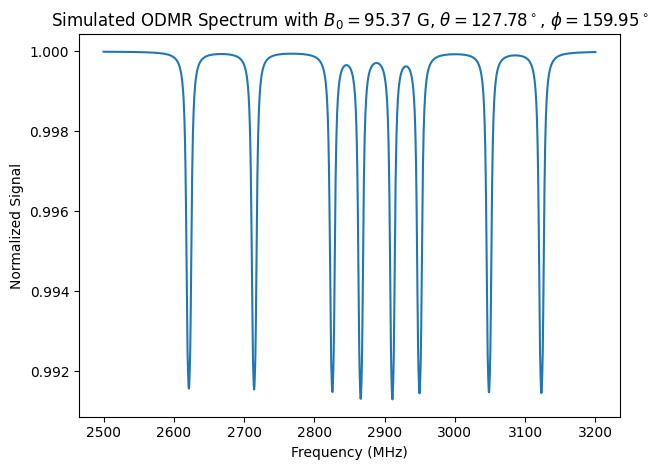

In [20]:
B0, th_deg, ph_deg = 95.365917, 127.776856, 159.951952
width, amp = 2.25, 0.1
f = np.linspace(2500.0, 3200.0, 2000)
y8, c8 = gen_spectrum_nv(B0, th_deg, ph_deg, width, amp, f)

print("Center Frequencies (MHz): ", c8)

plt.figure()
plt.plot(f, y8)
plt.title(
    rf"Simulated ODMR Spectrum with $B_0={B0:.2f}$ G, $\theta={th_deg:.2f}^\circ$, $\phi={ph_deg:.2f}^\circ$"
)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Normalized Signal")
plt.tight_layout()
plt.show()